In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from tqdm import tqdm
import numba
import time

# Introduction to NUMBA

## What is NUMBA? 

NUMBA is a just-in-time compiler (JIT) to translate code written in Python into **optimized** machine code! It replaces thereby the slower Python interpreter to modify and compile your code. An huge advantage of NUMBA is its
compatibility with for-loops *and* with numpy functions! Our trade-off between manual code modifications and performance gain should be therefore minimal.

## Gimme speed!!!

In [2]:
def example(pos):
    
    N = len(pos)
    distances = np.zeros(N)
    
    i = 0
    
    for r1 in pos:
        for r2 in pos:
            
            distances[i] = np.sqrt(np.sum((r1-r2)**2))
            
    return 'Success'

In [ ]:
@numba.jit(nopython = True, fastmath = True)
def example_with_numba(pos):
    
    N = len(pos)
    distances = np.zeros(N)
    
    i = 0
    
    for r1 in pos:
        for r2 in pos:
            
            distances[i] = np.sqrt(np.sum((r1-r2)**2))
            
    return 'Success'

In [ ]:
POS = np.random.randn(200, 3)

In [5]:
%timeit example(POS)

297 ms ± 668 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit example_with_numba(POS)

2.93 ms ± 8.77 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [155]:
#Caveat 1 - First compilation!

In [156]:
try: del example_with_numba_caveat
except: pass

@numba.jit(nopython = True, fastmath = True)
def example_with_numba_caveat(pos):
    
    N = len(pos)
    distances = np.zeros(N)
    
    i = 0
    
    for r1 in pos:
        for r2 in pos:
            
            distances[i] = np.sqrt(np.sum((r1-r2)**2))
            
    return 'Success'

POS = np.random.randn(200, 3)
start_time = time.time()
example_with_numba_caveat(POS)
print('First compilation:', time.time() - start_time)
start_time = time.time()
example_with_numba_caveat(POS)
print('Second compilation:', time.time() - start_time)

First compilation: 0.15744447708129883
Second compilation: 0.0030133724212646484


In [157]:
#Caveat 2 - Cryptic Errors!

In [158]:
@numba.jit(nopython = True, fastmath = True)
def example_with_numba_caveat_2(pos):
    
    Mean = np.mean(pos, axis = 0)
            
    return Mean

In [159]:
POS = np.random.randn(200, 3)
example_with_numba_caveat_2(POS)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function mean at 0x7fd6680a1ee0>) found for signature:
 
 >>> mean(array(float64, 2d, C), axis=Literal[int](0))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'Numpy_method_redirection.generic': File: numba/core/typing/npydecl.py: Line 348.
    With argument(s): '(array(float64, 2d, C), axis=Literal[int](0))':
   Rejected as the implementation raised a specific error:
     TypingError: numba doesn't support kwarg for mean
  raised from /home/rrzelinuxhome/xy35beqy/.conda/envs/MD-Engine/lib/python3.9/site-packages/numba/core/typing/npydecl.py:370

During: resolving callee type: Function(<function mean at 0x7fd6680a1ee0>)
During: typing of call at <ipython-input-158-7c0cca029ba5> (4)


File "<ipython-input-158-7c0cca029ba5>", line 4:
def example_with_numba_caveat_2(pos):
    <source elided>
    
    Mean = np.mean(pos, axis = 0)
    ^


# MD - Code

In [3]:
def init_pos(N, Grid, L):
    
    xmin = ymin = zmin = Grid
    xmax = ymax = zmax = L
    
    X, Y, Z = np.mgrid[xmin:xmax:Grid, ymin:ymax:Grid, zmin:zmax:Grid]
    positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
    init = np.random.choice(len(positions.T), replace = False, size = N)
    
    return positions.T[init]

def init_vel(N, SD, DIS):
    
    if DIS == 'normal':
        assert SD > 0, 'STD should be > 0'
        
        return np.random.normal(size = (N, 3), loc = 0, scale = SD)
    
    if DIS == 'uniform':
        
        return np.random.uniform(size = (N, 3))
    
def init(N, Grid, L, SD, DIS):
    
    return init_pos(N, Grid, L), init_vel(N, SD, DIS)

In [4]:
def write_file(FILE1, FILE2, FILE3, FILE4, coords, vels, PE, KE, n_iter):


    #Coordinates are round to the second decimal position to faciliate saving
    round_ = 2

    #Write head for each frame12     
    FILE1.write('Model {}\n'.format(n_iter)) #Start of a frame
    FILE2.write('Model {}\n'.format(n_iter)) #Start of a frame
    N = coords.shape[0]

    #Just iterate over all coordinates and write them down line per line
    for i in range(N):

        #The PDB-formate is really strict the line below is from: https://cupnet.net/pdb-format/

        #ATOM  #ID   #NAME     #RESN      #RESID          #X    #Y     #Z
        coord_str = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}\n".format('ATOM', int(i),
                                                                                                                         'PAR', ' ', 'ARG',
                                                                                                                         ' ', int(i), ' ',
                                                                                                                         np.round(coords[i][0], round_)*10,
                                                                                                                         np.round(coords[i][1], round_)*10,
                                                                                                                         np.round(coords[i][2], round_)*10,
                                                                                                                          1.0, 1.0, 'ARG', ' ')


        FILE1.write(coord_str) #Write coordinates
        FILE2.write('{}\t\t{}\t\t{}\n'.format(vels[i][0], vels[i][1], vels[i][2])) #Write velocities
    FILE1.write('TER\nENDMDL\n') #End of a frame

    #Write down Temperature, Pressure and Volume
    FILE3.write('{};{}\n'.format(n_iter, PE))
    FILE4.write('{};{}\n'.format(n_iter, KE))
                                                

In [5]:
@numba.jit(nopython = True, fastmath = True)
def pbc_dist(r_ij, L):
    
    dist_vec = np.zeros(3)
    
    for i in range(3):
        
        abs_liste = np.array([r_ij[i], r_ij[i] + L, r_ij[i] - L])
        argmin_abs = np.argmin(np.abs(abs_liste))
        
        dist_vec[i] = abs_liste[argmin_abs]
        
    dist = np.linalg.norm(dist_vec)
        
    return dist, dist_vec

In [6]:
@numba.jit(nopython = True, fastmath = True)
def pair_list(r, N, rc, L):
    
    pair_list_x = []
    pair_list_y = []
    
    for i in range(0, N):
        for j in range(i+1, N):
            
            diff_ij = r[i] - r[j]
            
            dr_ij, r_ij = pbc_dist(diff_ij, L)
            
            if dr_ij <= rc: 
                pair_list_x.append(i)
                pair_list_y.append(j)
                
            else: pass
    
    return np.array([pair_list_x, pair_list_y], dtype = np.int32)

In [7]:
@numba.jit(nopython = True, fastmath = True)
def kinetic(v, m):
    
    return 0.5 * m * np.sum(v**2)

In [8]:
#@numba.jit(nopython = True, fastmath = True)
#def pbc(r, v, L):
#    r %= L
#    v -= np.mean(a = v, axis = 0)   
#    return r, v

@numba.jit(nopython = True, fastmath = True)
def pbc(r, v, L):
    
    r %= L
    
    mean = np.zeros(3)
    counter = 0
    for vec in v:
        mean += vec
        counter +=1
    mean /= counter
    v -= mean #np.mean(a = v, axis = 0)
    
    return r, v

In [9]:
@numba.jit(nopython = True, fastmath = True)
def pressure(N, V, T, dV):
    
    NA = 6.02214086
    
    S1 = N * constants.R * 1E-3 * T
    
    S2 = 1.0/3.0 * dV
    
  #  print('Ideal part:', S1, 'Real part:', S2)
    
    return (S1 + S2) * (1/V) * 1E+2 / NA

@numba.jit(nopython = True, fastmath = True)
def force(rdt, N, sig, eps, pair_mask, L, rc, T):
    
    f = np.zeros((N, 3))
    
    Vol = L * L * L
    
    dV_sum = 0
    
    pote = 0
    
    for pair in pair_mask.T:
        
        i, j = pair
            
        diff_ij = rdt[i] - rdt[j]
            
        dr_ij, r_ij = pbc_dist(diff_ij, L)
        
        if dr_ij <= rc:
            
            dV = 48. * eps * ((sig**12)*(dr_ij**-13) - 0.5 *  (sig**6)*(dr_ij**-7))
        
            f_ij = dV / dr_ij * r_ij

            f[i] += f_ij
            f[j] -= f_ij
        
            pote += 4. * eps * ((sig/dr_ij)**12 - (sig/dr_ij)**6)
            
            dV_sum += dV * dr_ij
            
    p = pressure(N, Vol, T, dV_sum)
    
    return f, pote, p

@numba.jit(nopython = True, fastmath = True)
def velocity_verlet(r, v, f, m, eps, sig, dt, boundary, N, L, pair_list_update, rc, rb, step, pair_mask, T):
    
    rdt = r + dt * v + f * dt**2 / 2 / m

    rdt, v = boundary(rdt, v, L)
    
    if not step % pair_list_update: pair_mask = pair_list(rdt, N, rb, L)
    
    fdt, pote, press = force(rdt, N, sig, eps, pair_mask, L, rc, T) 
    
    vdt = v + dt * (f + fdt) / 2 / m
    
    return rdt, vdt, fdt, pote, pair_mask, press
    
    

In [10]:
@numba.jit(nopython = True, fastmath = True)
def temperature(v, m, N):
    
    return (m * 1E+3 * np.sum(v**2)) / (3 * N * constants.R)

@numba.jit(nopython = True, fastmath = True)
def berendsen_thermostat(T0, T, dt, tau, v):
    
    v *= np.sqrt(1 + (dt/tau) * (T0/T - 1))
    
    return v

@numba.jit(nopython = True, fastmath = True)
def berendsen_barostat(P0, P, dt, beta, tau, L, r):
    
    mu = (1 + dt * beta * (P - P0) / tau)**(1./3.)
    
    L *= mu
    r *= mu
    
    return L, r

In [11]:
def main(n_steps, N, L, dt, static, TEMPS, TEMP0, PRESS0, init_random, boundary, update, pair_list_update, rc, rb, tauT, tauP, file1, file2, file3, file4, r_init = 0, v_init = 0, distri = 'normal'):
    
    m = 39.948 #a.m.u.
    sig = 0.34
    eps = 1.0
    beta = 1.8*10**(-4)
    
    f1, f2, f3, f4 = open(file1, 'w'), open(file2, 'w'), open(file3, 'w'), open(file4, 'w')
    
    s = str('CRYST1'+ str("{:9.3f}{:9.3f}{:9.3f}".format(L*10,L*10,L*10)) + "  90.00  90.00  90.00 P 1           1\n")
   # f1.write(s)
    
    if init_random: 
        sd = np.sqrt(constants.R * 0.001 * TEMPS / m)
        r, v = init(N, 0.5, L, sd, distri)
        
        if boundary == pbc: v -= np.mean(v, axis = 0)
        
    else:
        r = r_init
        v = v_init
        
    kin_ener = np.zeros(int(n_steps / update))
    pot_ener = np.zeros(int(n_steps / update))
    temp = np.zeros(int(n_steps / update))
    pressure = np.zeros(int(n_steps / update))
    vel_store = np.zeros((int(n_steps / update), N, 3))
    volume = np.zeros(int(n_steps / update))
    
    T = temperature(v, m, N)
    pair_mask = pair_list(r, N, rb, L)
    f, pote, press = force(r, N, sig, eps, pair_mask, L, rc, T)
    
    
    kine = kinetic(v, m)
    
    kin_ener[0] = kine
    pot_ener[0] = pote
    vel_store[0] = v
    temp[0] = T
    pressure[0] = press
    volume[0] = L**3
    
    write_file(f1, f2, f3, f4, r, v, pote, kine, 0)
        
    c = 1
    
    for step in tqdm(range(1, n_steps)):
    #for step in range(1, n_steps):
        
        r, v, f, pote, pair_mask, press = velocity_verlet(r, v, f, m, eps, sig, dt, boundary, N, L,
                                                          pair_list_update, rc, rb, step, pair_mask, T)
        
        if static:
            v = berendsen_thermostat(T0 = TEMP0, T = T, dt = dt, tau = tauT, v = v)
            L, r = berendsen_barostat(P0 = PRESS0, P = press, dt = dt, beta = beta, tau = tauP, L = L, r = r)
        
        T = temperature(v, m, N)
        
        if not step % update: 
            write_file(f1, f2, f3, f4, r, v, pote, kine, 0)
            
            kine = kinetic(v, m)
            
            kin_ener[c] = kine
            pot_ener[c] = pote
            vel_store[c] = v
            temp[c] = T
            pressure[c] = press
            volume[c] = L**3
            #print(L**3)
            c+=1
            
    return kin_ener, pot_ener, vel_store, temp, pressure, volume

In [12]:
ideal_volume(T = 100, N =100, P = 1)

NameError: name 'ideal_volume' is not defined

In [12]:
KINE_No_Static, POTE_No_Static, VEL_No_Static, TEMP_No_Static, PRESS_No_Static, VOL_No_Static = main(n_steps = 100000, N = 100, L = 11, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 4,
                                                                                                     init_random = 1, boundary = pbc, update = 100, pair_list_update = 10, rc = 1., rb = 1.5, 
                                                                                                     tauT = 1.0, tauP = .5, static = True, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt')

  0%|          | 0/99999 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(PRESS_No_Static)
plt.ylabel('bar')

In [ ]:
#@numba.jit(nopython = True, fastmath = True)
def test(pos):
    
    return np.where(pos < 0.5, np.where(pos < 0.1))

In [ ]:
test(np.random.randn(100))

# Energy of two particles - Only potential energy

In [ ]:
r_init = np.array([[5, 5, 4], [5, 5, 5]])
v_init = np.zeros((2, 3))

In [ ]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000, N = 2, L = 10, dt = 1E-1, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 1,
                                         pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

In [ ]:
np.save(arr = KINE, file='ENERGY_CONSERVATION_TWO_PARTICLES/KINE_VERY_SHORT')
np.save(arr = POTE, file='ENERGY_CONSERVATION_TWO_PARTICLES/POTE_VERY_SHORT')

In [ ]:
KINE_BIGGER_TIMESTEP = np.load('ENERGY_CONSERVATION_TWO_PARTICLES/KINE_VERY_SHORT.npy')
POTE_BIGGER_TIMESTEP = np.load('ENERGY_CONSERVATION_TWO_PARTICLES/POTE_VERY_SHORT.npy')

In [29]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 100000, N = 2, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 1,
                                         pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 99999/99999 [00:02<00:00, 43678.01it/s]


In [30]:
np.save(arr = KINE, file='ENERGY_CONSERVATION_TWO_PARTICLES/KINE_SHORT')
np.save(arr = POTE, file='ENERGY_CONSERVATION_TWO_PARTICLES/POTE_SHORT')

In [31]:
KINE_BIG_TIMESTEP = np.load('ENERGY_CONSERVATION_TWO_PARTICLES/KINE_SHORT.npy')
POTE_BIG_TIMESTEP = np.load('ENERGY_CONSERVATION_TWO_PARTICLES/POTE_SHORT.npy')

In [32]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 10000000, N = 2, L = 10, dt = 1E-5, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 1,
                                         pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 9999999/9999999 [03:26<00:00, 48370.36it/s]


In [33]:
np.save(arr = KINE, file='ENERGY_CONSERVATION_TWO_PARTICLES/KINE_LONG')
np.save(arr = POTE, file='ENERGY_CONSERVATION_TWO_PARTICLES/POTE_LONG')

In [34]:
KINE_SMALL_TIMESTEP = np.load('ENERGY_CONSERVATION_TWO_PARTICLES/KINE_LONG.npy')
POTE_SMALL_TIMESTEP = np.load('ENERGY_CONSERVATION_TWO_PARTICLES/POTE_LONG.npy')

In [35]:
t0 = np.linspace(0, 100, 1000)
t1 = np.linspace(0, 100, 100000)
t2 = np.linspace(0, 100, 10000000)

(15.0, 25.0)

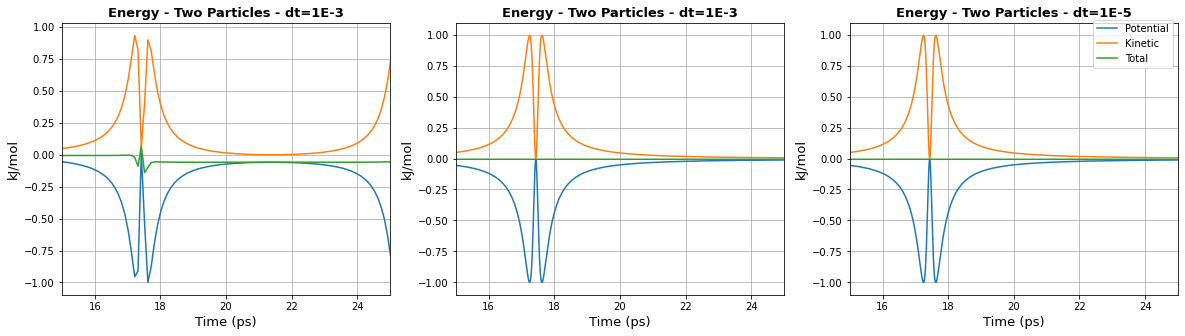

In [36]:


fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].plot(t0, POTE_BIGGER_TIMESTEP, label = 'Potential')
ax[0].plot(t0, KINE_BIGGER_TIMESTEP, label = 'Kinetic')
ax[0].plot(t0, KINE_BIGGER_TIMESTEP + POTE_BIGGER_TIMESTEP, label = 'Total')
ax[0].grid(True)
ax[0].set_title('Energy - Two Particles - dt=1E-3', fontweight = 'bold', fontsize = 13)
ax[0].set_ylabel('kJ/mol', fontsize = 13)
ax[0].set_xlabel('Time (ps)', fontsize = 13)

ax[1].plot(t1, POTE_BIG_TIMESTEP, label = 'Potential')
ax[1].plot(t1, KINE_BIG_TIMESTEP, label = 'Kinetic')
ax[1].plot(t1, KINE_BIG_TIMESTEP + POTE_BIG_TIMESTEP, label = 'Total')
ax[1].grid(True)
ax[1].set_title('Energy - Two Particles - dt=1E-3', fontweight = 'bold', fontsize = 13)
ax[1].set_ylabel('kJ/mol', fontsize = 13)
ax[1].set_xlabel('Time (ps)', fontsize = 13)
#ax[0].legend(bbox_to_anchor=(1., 1.03))

ax[2].plot(t2, POTE_SMALL_TIMESTEP, label = 'Potential')
ax[2].plot(t2, KINE_SMALL_TIMESTEP, label = 'Kinetic')
ax[2].plot(t2, KINE_SMALL_TIMESTEP + POTE_SMALL_TIMESTEP, label = 'Total')
ax[2].grid(True)
ax[2].set_title('Energy - Two Particles - dt=1E-5', fontweight = 'bold', fontsize = 13)
ax[2].set_ylabel('kJ/mol', fontsize = 13)
ax[2].set_xlabel('Time (ps)', fontsize = 13)
ax[2].legend(bbox_to_anchor=(1., 1.03))
#plt.savefig('Energy_Two_Particles.png', dpi = 300)

ax[0].set_xlim(15, 25)
ax[1].set_xlim(15, 25)
ax[2].set_xlim(15, 25)

/home/rrzelinuxhome/xy35beqy/.conda/envs/MD-Engine/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


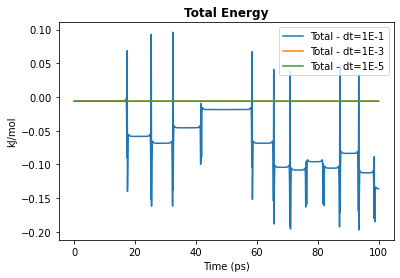

In [37]:
plt.plot(t0, KINE_BIGGER_TIMESTEP + POTE_BIGGER_TIMESTEP, label = 'Total - dt=1E-1')
plt.plot(t1, KINE_BIG_TIMESTEP + POTE_BIG_TIMESTEP, label = 'Total - dt=1E-3')
plt.plot(t2, KINE_SMALL_TIMESTEP + POTE_SMALL_TIMESTEP, label = 'Total - dt=1E-5')
plt.ylabel('kJ/mol')
plt.xlabel('Time (ps)')
plt.title('Total Energy', fontweight = 'bold')
plt.legend()

/home/rrzelinuxhome/xy35beqy/.conda/envs/MD-Engine/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


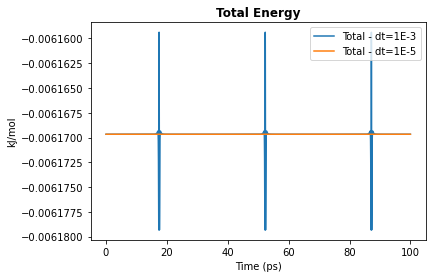

In [39]:
plt.plot(t1, KINE_BIG_TIMESTEP + POTE_BIG_TIMESTEP, label = 'Total - dt=1E-3')
plt.plot(t2, KINE_SMALL_TIMESTEP + POTE_SMALL_TIMESTEP, label = 'Total - dt=1E-5')
plt.ylabel('kJ/mol')
plt.xlabel('Time (ps)')
plt.title('Total Energy', fontweight = 'bold')
plt.legend()

# With and without Pair-List

In [80]:
#Start from the same configuration each time
sd = np.sqrt(constants.R * 0.001 * 300 / 39.948)
r_init, v_init = init(50, 0.5, 10, sd, 'normal')
v_init -= np.mean(v_init , 0)

In [81]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000000, N = 50, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                         pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [36:49<00:00, 452.65it/s]


In [82]:
np.save(arr = KINE, file = 'TESTING_PAIR_LIST/KINE_1_WO_CO')
np.save(arr = POTE, file = 'TESTING_PAIR_LIST/POTE_1_WO_CO')
KINE_1_WO_CO = np.load('TESTING_PAIR_LIST/KINE_1_WO_CO.npy')
POTE_1_WO_CO = np.load('TESTING_PAIR_LIST/POTE_1_WO_CO.npy')

In [83]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000000, N = 50, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                         pair_list_update = 1, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [17:28<00:00, 953.34it/s]


In [84]:
np.save(arr = KINE, file = 'TESTING_PAIR_LIST/KINE_1')
np.save(arr = POTE, file = 'TESTING_PAIR_LIST/POTE_1')
KINE_1 = np.load('TESTING_PAIR_LIST/KINE_1.npy')
POTE_1 = np.load('TESTING_PAIR_LIST/POTE_1.npy')

In [99]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000000, N = 50, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                         pair_list_update = 5, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [03:55<00:00, 4248.83it/s]


In [100]:
np.save(arr = KINE, file = 'TESTING_PAIR_LIST/KINE_5')
np.save(arr = POTE, file = 'TESTING_PAIR_LIST/POTE_5')
KINE_5 = np.load('TESTING_PAIR_LIST/KINE_5.npy')
POTE_5 = np.load('TESTING_PAIR_LIST/POTE_5.npy')

In [85]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000000, N = 50, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                         pair_list_update = 10, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [02:01<00:00, 8220.42it/s]


In [86]:
np.save(arr = KINE, file = 'TESTING_PAIR_LIST/KINE_10')
np.save(arr = POTE, file = 'TESTING_PAIR_LIST/POTE_10')
KINE_10 = np.load('TESTING_PAIR_LIST/KINE_10.npy')
POTE_10 = np.load('TESTING_PAIR_LIST/POTE_10.npy')

In [87]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000000, N = 50, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                         pair_list_update = 20, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [01:16<00:00, 13050.67it/s]


In [88]:
np.save(arr = KINE, file = 'TESTING_PAIR_LIST/KINE_20')
np.save(arr = POTE, file = 'TESTING_PAIR_LIST/POTE_20')
KINE_20 = np.load('TESTING_PAIR_LIST/KINE_20.npy')
POTE_20 = np.load('TESTING_PAIR_LIST/POTE_20.npy')

In [89]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000000, N = 50, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                         pair_list_update = 30, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [01:01<00:00, 16376.63it/s]


In [90]:
np.save(arr = KINE, file = 'TESTING_PAIR_LIST/KINE_30')
np.save(arr = POTE, file = 'TESTING_PAIR_LIST/POTE_30')
KINE_30 = np.load('TESTING_PAIR_LIST/KINE_30.npy')
POTE_30 = np.load('TESTING_PAIR_LIST/POTE_30.npy')

In [91]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000000, N = 50, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                         pair_list_update = 40, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [00:53<00:00, 18706.83it/s]


In [92]:
np.save(arr = KINE, file = 'TESTING_PAIR_LIST/KINE_40')
np.save(arr = POTE, file = 'TESTING_PAIR_LIST/POTE_40')
KINE_40 = np.load('TESTING_PAIR_LIST/KINE_40.npy')
POTE_40 = np.load('TESTING_PAIR_LIST/POTE_40.npy')

In [93]:
KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 1000000, N = 50, L = 10, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                         pair_list_update = 50, rc = 1., rb = 1.5, file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                         r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [00:47<00:00, 20933.75it/s]


In [97]:
np.save(arr = KINE, file = 'TESTING_PAIR_LIST/KINE_50')
np.save(arr = POTE, file = 'TESTING_PAIR_LIST/POTE_50')
KINE_50 = np.load('TESTING_PAIR_LIST/KINE_50.npy')
POTE_50 = np.load('TESTING_PAIR_LIST/POTE_50.npy')

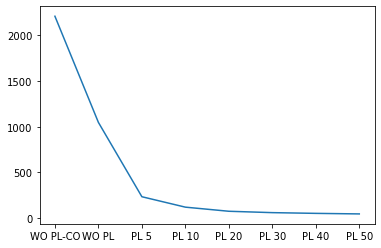

In [101]:
Timer = [2209, 1048, 235, 121, 76, 61, 53, 47]
PL = ["WO PL-CO", "WO PL", "PL 5", "PL 10", "PL 20", "PL 30", "PL 40", "PL 50"]
plt.plot(PL, Timer)

In [104]:
t = np.linspace(0, 1000, 10000)

Text(0.5, 0, 'Time (ps)')

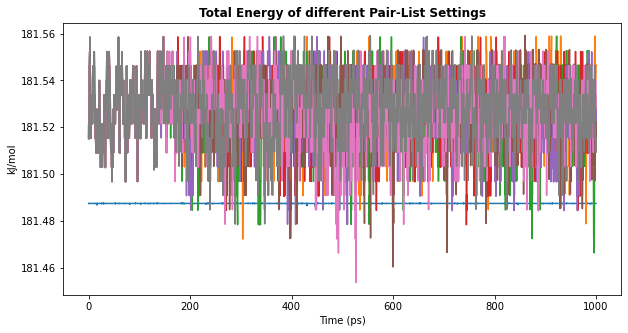

In [109]:
fig = plt.figure(figsize = (10, 5))
plt.plot(t, KINE_1_WO_CO[:] + POTE_1_WO_CO[:], label = 'No Pair - No CutOff')
plt.plot(t, KINE_1[:] + POTE_1[:], label = 'No Pair')
plt.plot(t, KINE_5[:] + POTE_5[:], label = 'Update 5')
plt.plot(t, KINE_10[:] + POTE_10[:], label = 'Update 10')
plt.plot(t, KINE_20[:] + POTE_20[:], label = 'Update 20')
plt.plot(t, KINE_30[:] + POTE_30[:], label = 'Update 30')
plt.plot(t, KINE_40[:] + POTE_40[:], label = 'Update 40')
plt.plot(t, KINE_50[:] + POTE_50[:], label = 'Update 50')

#plt.ylim([1.4, 1.45])
plt.title('Total Energy of different Pair-List Settings', fontweight = 'bold')
#plt.legend()
plt.ylabel('kJ/mol')
plt.xlabel('Time (ps)')

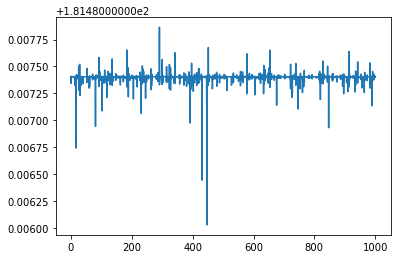

In [111]:
plt.plot(t, KINE_1_WO_CO[:] + POTE_1_WO_CO[:], label = 'No Pair - No CutOff')
#plt.plot(t, KINE_1[:] + POTE_1[:], label = 'No Pair')
#plt.plot(t, KINE_5[:] + POTE_5[:], label = 'Update 5')

In [123]:
#Start from the same configuration each time
sd = np.sqrt(constants.R * 0.001 * 300 / 39.948)
r_init, v_init = init(10, 0.5, 5, sd, 'normal')
v_init -= np.mean(v_init , 0)

In [148]:
KINE_DT5, POTE_DT5, VEL_DT5, TEMP_DT5, PRESS_DT5, VOL_DT5 = main(n_steps = 100000000, N = 10, L = 5, dt = 1E-5, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 10000,
                                                                 pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                                                 r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 99999999/99999999 [2:38:55<00:00, 10487.45it/s]  


In [149]:
KINE_DT3, POTE_DT3, VEL_DT3, TEMP_DT3, PRESS_DT3, VOL_DT3 = main(n_steps = 1000000, N = 10, L = 5, dt = 1E-3, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 100,
                                                                 pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                                                 r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [01:30<00:00, 11031.94it/s]


In [339]:
KINE_DT2, POTE_DT2, VEL_DT2, TEMP_DT2, PRESS_DT2, VOL_DT2 = main(n_steps = 1000000, N = 10, L = 5, dt = 1E-2, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 10,
                                                                 pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                                                 r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 999999/999999 [01:36<00:00, 10351.55it/s]


In [150]:
KINE_DT1, POTE_DT1, VEL_DT1, TEMP_DT1, PRESS_DT1, VOL_DT1 = main(n_steps = 10000, N = 10, L = 5, dt = 1E-1, TEMPS = 100, TEMP0 = 100, PRESS0 = 1, init_random = 0, boundary = pbc, update = 1,
                                                                 pair_list_update = 1, rc = 1000., rb = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                                                 r_init = r_init, v_init = v_init, static = False, tauT = 1.0, tauP = 1.0)

100%|██████████| 9999/9999 [00:01<00:00, 9464.77it/s]


In [342]:
TE_DT5 = KINE_DT5 + POTE_DT5
TE_DT3 = KINE_DT3 + POTE_DT3
TE_DT2 = KINE_DT2 + POTE_DT2
TE_DT1 = KINE_DT1 + POTE_DT1

In [ ]:
np.save()

In [155]:
len(TE_DT3)

10000

"Drift is calculated by performing a least-squares fit of the data to a straight line. The reported total drift is the difference of the fit at the first and last point." - GROMACS

In [345]:
t_DT5 = np.linspace(0, 1000, 10000)
t_DT3 = np.linspace(0, 1000, 10000)
t_DT2 = np.linspace(0, 1000, 10000)
t_DT1 = np.linspace(0, 1000, 10000)

In [157]:
def get_drift(x, y):
    
    fit_a, fit_b = np.polyfit(x = x, y = y, deg = 1)
    
    first = fit_a * x[0] + fit_b
    last = fit_a * x[-1] + fit_b
    
    return last - first
    

In [346]:
print("Drift of dt=1E-5:", get_drift(t_DT5, TE_DT5))
print("Drift of dt=1E-3:", get_drift(t_DT3, TE_DT3))
print("Drift of dt=1E-2:", get_drift(t_DT2, TE_DT2))
print("Drift of dt=1E-1:", get_drift(t_DT1, TE_DT1))

Drift of dt=1E-5: -2.554692457579222e-09
Drift of dt=1E-3: 4.6088674565680776e-07


TypeError: expected x and y to have same length

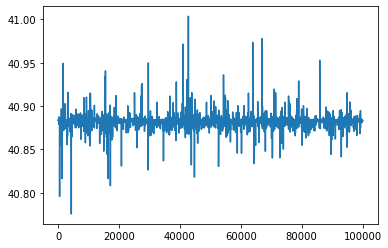

In [343]:
#plt.plot(TE_DT5)
plt.plot(TE_DT2)
#plt.plot(TE_DT1)
#plt.ylim(40.88, 40.885)
#plt.xlim(0, 5000)

(array([2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 3.300e+01, 8.918e+03,
        1.038e+03, 3.000e+00, 0.000e+00, 2.000e+00]),
 array([40.88368235, 40.88368236, 40.88368237, 40.88368238, 40.8836824 ,
        40.88368241, 40.88368242, 40.88368243, 40.88368244, 40.88368246,
        40.88368247]),
 <BarContainer object of 10 artists>)

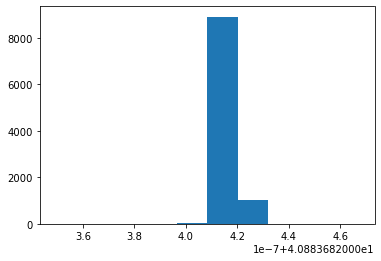

In [338]:
plt.hist(TE_DT5)


# Scaling

In [113]:
def get_vol(p, n):
    
    return (n/p)**(1/3)

2.0

In [108]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 10, L = 2, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:00<00:00, 381.92it/s]


In [116]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 100, L = 4.3, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:02<00:00, 33.29it/s]


In [118]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 300, L = 6.21, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:15<00:00,  6.26it/s]


In [120]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 500, L = 7.37, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:38<00:00,  2.60it/s]


In [121]:
get_vol(1.25, 700)

8.242570599617112

In [122]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 700, L = 8.24, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 10, rc = 1., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [01:12<00:00,  1.36it/s]


In [123]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 10, L = 2, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [00:00<00:00, 158.37it/s]


In [124]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 100, L = 4.3, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

100%|██████████| 99/99 [01:00<00:00,  1.63it/s]


In [ ]:
26*60 +55

In [ ]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 300, L = 6.21, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

In [128]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 500, L = 7.37, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

  2%|▏         | 2/99 [02:45<2:13:29, 82.57s/it]


KeyboardInterrupt: 

In [129]:
KINE_Scaling10, POTE_Scaling10 = main(n_steps = 100, N = 700, L = 8.24, dt = 1E-3, TEMPS = 100, init_random = 1, boundary = pbc, update = 100,
                                      pair_list_update = 1, rc = 1000., file1 = 'Test.pdb', file2 = 'Vel.txt', file3 = 'POTE.txt', file4 = 'KINE.txt',
                                      r_init = r_init, v_init = v_init)

  1%|          | 1/99 [03:27<5:39:11, 207.66s/it]


KeyboardInterrupt: 

In [131]:
2*60*60+13*60+29

8009

Text(0, 0.5, 'Time (s)')

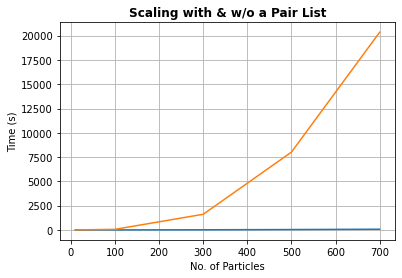

In [134]:
WITH_PAIR = [0, 2, 15, 38, 72]
WO_PAIR = [0, 60, 1610, 8009, 20351]
N = [10, 100, 300, 500, 700]
plt.plot(N, WITH_PAIR, label = 'With Pair-List')
plt.plot(N, WO_PAIR, label = 'Without Pair-List')
plt.grid(True)
plt.title('Scaling with & w/o a Pair List', fontweight = 'bold')
plt.xlabel('No. of Particles')
plt.ylabel('Time (s)')

# Not normal

In [192]:
KINE_NN, POTE_NN, VEL_NN, TEMP_NN, PRESS_NN, VOL_NN = main(n_steps = 100000, N = 1000, L = 34.60, dt = 1E-3, TEMPS = 300, TEMP0 = 300, PRESS0 = 1, init_random = 1, boundary = pbc, update = 100,
                                                                 pair_list_update = 10, rc = 1., rb = 1.5, file1 = 'Test_NN.pdb', file2 = 'Vel_NN.txt', file3 = 'POTE_NN.txt', file4 = 'KINE_NN.txt',
                                                                 r_init = r_init, v_init = v_init, static = True, tauT = 1.0, tauP = 1.0, distri = "uniform")

100%|██████████| 99999/99999 [1:06:38<00:00, 25.01it/s]


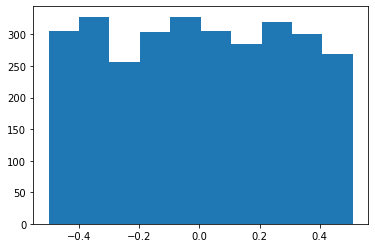

In [193]:
ax = plt.hist(VEL_NN[0].flatten(), bins = 10)

(array([  4.,   2.,   9.,   8.,  11.,  32.,  96., 125., 138., 138., 154.,
        157., 139., 194., 203., 206., 179., 189., 178., 156., 159., 148.,
        127., 111.,  74.,  33.,  15.,   5.,   4.,   6.]),
 array([-0.72096715, -0.67417933, -0.62739151, -0.58060369, -0.53381587,
        -0.48702805, -0.44024022, -0.3934524 , -0.34666458, -0.29987676,
        -0.25308894, -0.20630112, -0.1595133 , -0.11272548, -0.06593766,
        -0.01914984,  0.02763798,  0.0744258 ,  0.12121362,  0.16800144,
         0.21478926,  0.26157708,  0.3083649 ,  0.35515272,  0.40194054,
         0.44872836,  0.49551618,  0.542304  ,  0.58909182,  0.63587964,
         0.68266746]),
 <BarContainer object of 30 artists>)

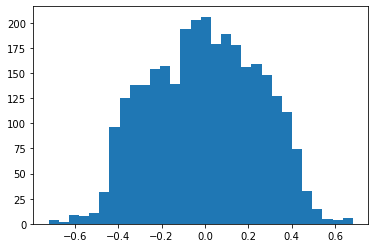

In [194]:
plt.hist(VEL_NN[-1].flatten(), bins = 30)

# p-V Diagrams

In [23]:
def create_pV_point(p):

    id_L = np.round(ideal_volume(T = TEMPER, N = N_Par, P = p), 3)
    
    print(id_L)

    KINE, POTE, VEL, TEMP, PRESS, VOL = main(n_steps = 150000, N = N_Par, L = id_L, dt = 1E-3,
                                             TEMPS = TEMPER, TEMP0 = TEMPER, PRESS0 = p, init_random = True,
                                             boundary = pbc, update = 100,
                                             pair_list_update = 10, rc = 1., rb = 1.5,
                                             file1 = 'Test.pdb', file2 = 'Vel.txt',
                                             file3 = 'POTE.txt', file4 = 'KINE.txt',
                                             static = True, tauT = 1.0, tauP = .1)
    
    return KINE, POTE, VEL, TEMP, PRESS, VOL
    

In [58]:
N_Par = 200
TEMPER = 40

Press = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16]

pV_KINE = []
pV_POTE = []
pV_VEL = []
pV_PRESS = []
pV_VOL = []

In [59]:
@numba.jit(nopython = True, fastmath = True)
def ideal_volume(T, N, P):
    
    return ((T * N * 1.38) / (P * 1E+1))**(1./3.)

In [ ]:
from multiprocessing import Pool


pool = Pool(10)
for res in pool.map(create_pV_point, Press):
    
    KINE, POTE, VEL, TEMP, PRESS, VOL = res
    
    pV_KINE.append(KINE)
    pV_POTE.append(POTE)
    pV_VEL.append(VEL)
    pV_PRESS.append(PRESS)
    pV_VOL.append(VOL)

6.044
5.168
6.511
10.3355.6885.403


8.203
4.969
4.7977.166


  4%|▍         | 6373/149999 [00:35<12:32, 190.80it/s]]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 87%|████████▋ | 131240/149999 [44:31<06:36, 47.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 97%|█████████▋| 145961/149999 [49:31<01:20, 50.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Noteb

In [ ]:
print("Fiunish")

In [ ]:
np.save(file = "KINE_pV_40K_tp_01_200.npy", arr = np.array(pV_KINE))
np.save(file = "POTE_pV_40K_tp_01_200.npy", arr = np.array(pV_POTE))
np.save(file = "VOL_pV_40K_tp_01_200.npy", arr = np.array(pV_VOL))
np.save(file = "PRESS_pV_40K_tp_01_200.npy", arr = np.array(pV_PRESS))

In [51]:
VOL_140 = np.load("VOL_pV_140K_tp_01_200.npy")
VOL_70 = np.load("VOL_pV_70K_tp_01_200.npy")

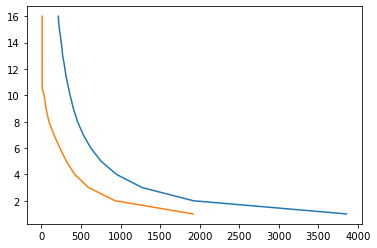

In [55]:
plt.plot(VOL_140[:, -100:].mean(1), Press)
plt.plot(VOL_70[:, -100:].mean(1), Press)

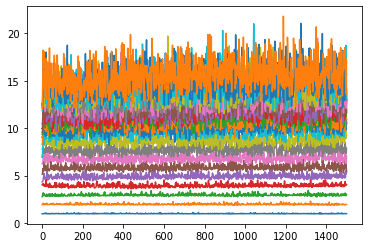

In [49]:
Pressure = []
for idx, pact in enumerate(pV_PRESS):
    Pressure.append(ideal_volume(T = 50, N = 500, P = Press[idx]))
    #Pressure.append(np.mean(pact[:100]))
    plt.plot(pact)
    

In [38]:
Ideal_Volumina = [ideal_volume(T = 70, N = 200, P = p)**(3) for p in Press]

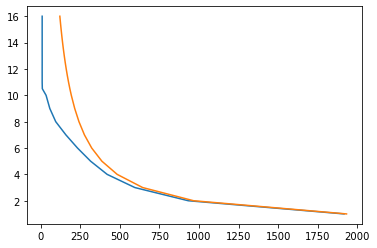

In [39]:
plt.plot(Volumina, Press)
plt.plot(Ideal_Volumina, Press)

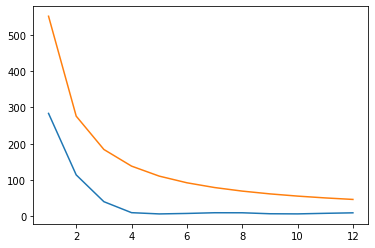

In [44]:
plt.plot(pressure, Vol)
plt.plot(pressure, [ideal_volume(T = 40, N = 100, P = p)**3 for p in pressure], "-")

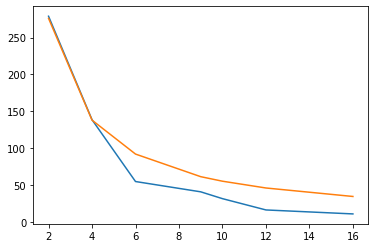

In [316]:
plt.plot(P, V, "-")
plt.plot(P, [ideal_volume(T = 40, N = 100, P = p)**3 for p in P], "-")

In [294]:
[ideal_volume(T = 40, N = 100, P = p) for p in P]

[3.2554150357632157,
 4.514357435474001,
 6.510830071526431,
 3.583047871015946,
 5.167649252363622,
 3.807556523926606]

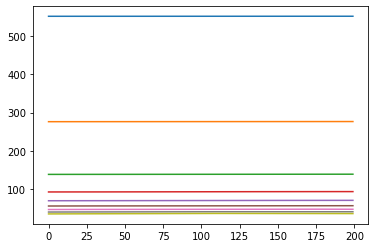

In [239]:
vol = []
for p in pV_VOL:
    plt.plot(p[:])
    vol.append(p[:].mean())

0
1
4
9
16
25
36
49
64
81
100
121
144
169
196
225
256
289
324
361


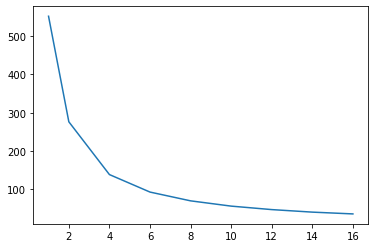

In [241]:
plt.plot(Press, vol)
plt.xlim(0, )